# Use wateRinfo package to understand eel behaviour in the Scheldt river

## Introduction

The [Fish acoustic receiver network](http://lifewatch.be/en/fish-acoustic-receiver-network) is a EU Lifewatch supported infrastructure to track the distribution, movements and habitat use of migratory fish. Among other species, we tag and study eels to get data-based knowledge about their migration behaviour. By using this information we can propose effective policy measures to support this criticially endangered species.

Interested in the fascinating live of the eel and eager to understand what we're talking about when mentioning `transmitters` and `receivers`? Check out the animated video starring affiliated Phd student Pieterjan Verhelst:

[![Tagging research on eel in Belgium](https://img.youtube.com/vi/7YQVgl3QPyY/0.jpg)](https://www.youtube.com/watch?v=7YQVgl3QPyY)

Pieter-Jan provided an interesting subset of the fish tracking data. In this blog post, we'll do some explorative data analysis and show a research application of the [wateRinfo R package](https://inbo.github.io/wateRinfo/) which was recently accepted through the rOpenSci onboarding process.

## Eel tracking data

Let's start with the tracking data of the eels and check the favorite places of two of our tagged eels to hang out in the Scheldt estuary.

In [1]:
library(tidyverse)
library(lubridate)
library(leaflet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0.9000     ✔ purrr   0.2.5     
✔ tibble  1.4.2          ✔ dplyr   0.7.6     
✔ tidyr   0.8.1          ✔ stringr 1.3.1     
✔ readr   1.1.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
# HIDE CELL
eels <- read_csv("../data/eels.csv", col_types = cols())

The eel tracking data contains the residence time intervals between the `Arrival` and `Departure` of an eel, supplied with a `Transmitter`, at a certain `Receiver` station. Each `Receiver` station does have a `latitude`, `longitude` and a `station` name:

In [3]:
# HIDE CELL
head(eels)

Date,Transmitter,Receiver,latitude,longitude,station,Arrival,Departure,Detections,residencetime
2016-10-11,A69-1601-52622,VR2W-112287,51.00588,3.77876,s-2,2016-10-11 17:41:00,2016-10-11 18:14:00,42,1980
2016-10-11,A69-1601-52622,VR2W-112297,51.00164,3.85695,s-Wetteren,2016-10-11 20:08:00,2016-10-11 20:25:00,10,1020
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 03:06:00,2016-10-12 10:15:00,175,25740
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 14:50:00,2016-10-12 23:11:00,185,30060
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 15:34:00,2016-10-13 19:22:00,70,13680
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 03:10:00,2016-10-13 11:12:00,121,28920


For each interval, the number of raw detections of the `Receiver` for each `Transmitter` is provided together with the derived `residencetime` of the `Transmitter`, i.e. the eel. As such, we can calculate the eels *favourite place to hang out* by calculating the total residence time around each receiver.

On a map, this looks like:

In [4]:
# HIDE CELL
residence <- eels %>% 
    group_by(Receiver, latitude, longitude, Transmitter) %>%
    summarise(total_residence = sum(residencetime))

HTML widgets cannot be represented in plain text (need html)
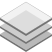
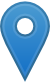

In [5]:
# HIDE CELL
tag_colors <- colorFactor(c("#e66101", "#5e3c99"), eels$Transmitter)

m <- leaflet(data = residence, width = 600, height = 400) %>%
  addTiles() %>%  
  addCircleMarkers(~longitude, ~latitude, popup = ~Receiver, fillColor = ~tag_colors(Transmitter),
                   radius = ~total_residence/3600, stroke=FALSE, fillOpacity = 0.6) %>%
  addLegend(values = ~Transmitter, pal = tag_colors)
m

Apparently, the eel carrying transmitter `A69-1601-52622` likes to be around the municipality Hamme and a section between the municipalities Wetteren and Wichelen, whereas eel `A69-1601-52644` prefers to swim around different sections of the Scheldt river.

For the remainder of this post, let's give both eels a more compelling name than the Transmitter code their carrying. So the eel with transmitter `A69-1601-52622` is officially named **Greg** (the roots of the famous cyclist [Greg Van Aevermaet](https://en.wikipedia.org/wiki/Greg_Van_Avermaet) is in Hamme as well) and the eel with transmitter `A69-1601-52644` will be called **Olivier**!

The map overview with total residence time lacks temporal information. We do not know *when* the eels were passing these receiever stations. Let's reconfigure adn plot the eel tracking data to see their route in the Scheldt river as function of time:

In [6]:
eels <- eels %>%
    mutate(eel_name=recode(Transmitter, `A69-1601-52622` = "Greg", `A69-1601-52644` = "Olivier"))

In [7]:
# HIDE CELL
distance_from_sea <- read_csv("../data/distance_from_sea.csv", col_types = cols())
eels <- eels %>%
    left_join(distance_from_sea, by = "station")

In [8]:
# HIDE CELL
station_municipality <- read_csv("../data/link_station_municipality.csv", col_types = cols())
station_municipality <- station_municipality %>% 
    left_join(eels %>% select(station, distance_to_refence_station) %>% 
              distinct(), by = "station")

In [9]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=6)

In [10]:
head(eels)

Date,Transmitter,Receiver,latitude.x,longitude.x,station,Arrival,Departure,Detections,residencetime,eel_name,reference_station,distance_to_refence_station,station_id,longitude.y,latitude.y,station_type
2016-10-11,A69-1601-52622,VR2W-112287,51.00588,3.77876,s-2,2016-10-11 17:41:00,2016-10-11 18:14:00,42,1980,Greg,ws-DL7,155620.9,VR2W-112287,3.77876,51.00588,receiver
2016-10-11,A69-1601-52622,VR2W-112297,51.00164,3.85695,s-Wetteren,2016-10-11 20:08:00,2016-10-11 20:25:00,10,1020,Greg,ws-DL7,149062.2,VR2W-112297,3.85695,51.00164,receiver
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 03:06:00,2016-10-12 10:15:00,175,25740,Greg,ws-DL7,143593.5,VR2W-115438,3.92527,51.01680,receiver
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 14:50:00,2016-10-12 23:11:00,185,30060,Greg,ws-DL7,143593.5,VR2W-115438,3.92527,51.01680,receiver
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 15:34:00,2016-10-13 19:22:00,70,13680,Greg,ws-DL7,143593.5,VR2W-115438,3.92527,51.01680,receiver
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 03:10:00,2016-10-13 11:12:00,121,28920,Greg,ws-DL7,143593.5,VR2W-115438,3.92527,51.01680,receiver


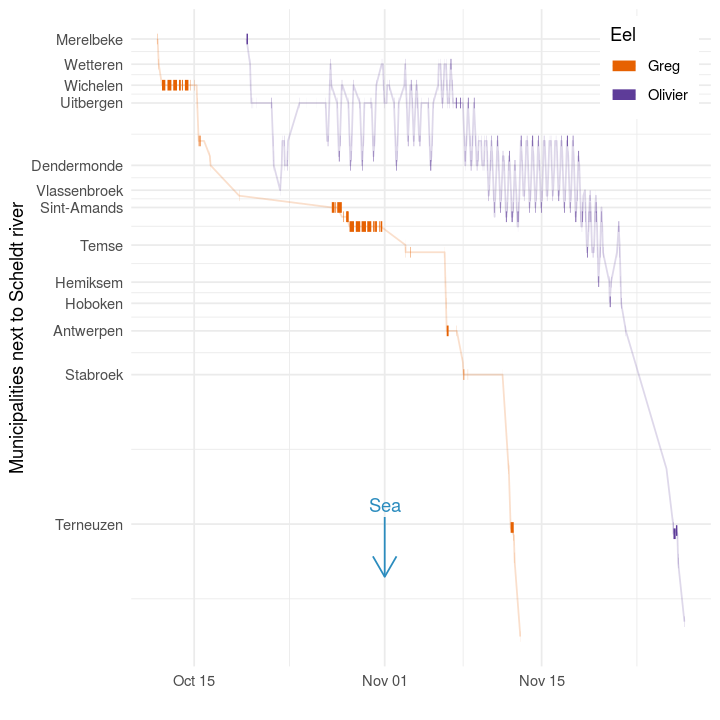

In [11]:
# HIDE CELL
ggplot(eels, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, 
                 yend = distance_to_refence_station,
                 color = eel_name)) +
    geom_segment(size = 3) + xlab("") + ylab("") +
    geom_line(data = eels, aes(x = Arrival, y = distance_to_refence_station), 
              alpha = 0.2, size = 0.5) +
    scale_y_continuous("Municipalities next to Scheldt river", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    scale_color_manual(values = c("#e66101", "#5e3c99"), guide = guide_legend()) +
    annotate("text", x = as_datetime("2016-11-01"),
             y = max(eels$distance_to_refence_station) * 0.22, 
             colour = "#2b8cbe", label = "Sea") +
    annotate("segment", x = as_datetime("2016-11-01"), xend = as_datetime("2016-11-01"),
             y = max(eels$distance_to_refence_station) * 0.2, 
             yend = max(eels$distance_to_refence_station) * 0.1, 
                 arrow = arrow(length = unit(0.5, "cm")), color = "#2b8cbe") +
    theme_minimal() +
    theme(legend.position = c(.98, .99),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6),
          legend.background =  element_rect(fill="white", color = "transparent")) +
    guides(color=guide_legend(title="Eel"))

For both eel, we picked up the signal around Ghent/Merelbeke and they resided for a while in the Scheldt river before migration towards the sea. Once left, they start their long journey towards the Sargasso Sea. However, both eel clearly seem to behave differently while moving towards the sea. 

Similar to the map representation, Greg is residential for longer periods on a few specific places, whereas Olivier travels around much more along the river section between Temse and Merelbeke. 

The periodic movement pattern of Olivier during the second half of november 2016 is of particular interest, as it looks like a tidal frequency. It would be interesting to compare the movement pattern with real water level data from the Scheldt river...  that's what the [wateRinfo](https://inbo.github.io/wateRinfo/) package is all about!

**Note:**
* To represent the data along a straight line (y-axis), we calculated the distances from each station to a reference station close to the sea (`ws-DL7`) . We used a `costDistance` function to derive the distances along the Scheldt river. Interested? See [the code repository](https://github.com/stijnvanhoey/wateRinfo_post) for more the details on the derivation.

### Tidal data from Waterinfo

[Waterinfo.be](http://waterinfo.be), managemed by the [Flemisch Environmental agency (VMM)](https://en.vmm.be/) and [Flanders Hydraulics Research (WL)](https://www.waterbouwkundiglaboratorium.be/en/home), is a great resource for a wide set of abiotic variables. The water height of the Scheldt river is among these variables, providing detailed information of [tidal behaviour](https://www.waterinfo.be/default.aspx?path=NL/Thema/Getij_Actueel). 

However, downloading the data from the website is both tedious (too much clicking) and not repeatable for future analysis. The goal of our [wateRinfo package](https://github.com/inbo/wateRinfo) is to facilitate access to the variety of data by providing an R interface to download time series data. We will use the package to access tidal/waterheight data.

For installation instructions, see [the package documentation](https://inbo.github.io/wateRinfo/). As wateRinfo is not registered on CRAN, you will need the `devtools` package to install the wateRinfo package. Once installed, load the library:

In [12]:
library(wateRinfo)

As water levels in the Scheldt river are not among their core supported variables, we use the tidal stations overview as currently discussed on the wateRinfo [GitHub issues](https://github.com/inbo/wateRinfo/issues/11#issuecomment-442901628). This list of station identifiers is precompiled to derive all tidal VMM station timeseries:

In [13]:
# HIDE CELL
ts_id_tide <- read_csv("../data/scheldt_tide_waterinfo_identifiers.csv", col_types = cols())

non_scheldt_stations <- c("Walem tij/Rupel", "Duffel-sluis tij", "Lier Molbrug tij/Nete",
                           "Kessel tij/Grote Nete", "Emblem tij/Kleine Nete", 
                           "Mechelen Benedensluis tij/Dijle", "Mechelen Stuw Opwaarts tij/Dijle",
                           "Hombeek tij/Zenne", "Zemst tij/Zenne", "Gentbrugge tij/Zeeschelde",
                           "Waasmunster Manta tij/Durme", "Duffel Sluis tij/Nete", 
                           "Mechelen Stuw Afwaarts tij/Dijle")
ts_id_tide <- ts_id_tide %>%
    filter(!station_name %in% non_scheldt_stations) %>% # exclude non-scheldt stations
    filter(ts_name == "Pv.10")  # only the 10 min series

The following list provides an overview of the time series identifiers of the relevant measurement stations along the Scheldt River with a 10 minute interval:

In [14]:
head(ts_id_tide)

ts_value_id,datetime,req_timestamp,station_latitude,station_longitude,station_id,station_no,station_name,dataprovider,dataowner,significant,Portal_Bekken,station_no_short,ts_id,ts_name,parametertype_name,stationparameter_name
1,2018-11-29 15:30:00,NA,51.05264,4.197217,0430087,04zes42a-1066,Sint-Amands tij/Zeeschelde,MOW-HIC,HIC,0,Beneden-Scheldebekken,zes42a-1066,55419010,Pv.10,W,W
3,2018-11-29 15:30:00,NA,51.10964,4.173916,0430029,04dur01a-1066,Tielrode tij/Durme,MOW-HIC,HIC,0,Beneden-Scheldebekken,dur01a-1066,55565010,Pv.10,W,W
4,2018-11-29 15:32:00,NA,51.09256,4.170995,0430084,04zes39a-1066,Driegoten tij/Zeeschelde,MOW-HIC,HIC,0,Beneden-Scheldebekken,zes39a-1066,102376010,Pv.10,W,W
7,2018-11-29 15:30:00,NA,51.12281,4.218673,0430081,04zes36a-1066,Temse tij/Zeeschelde,MOW-HIC,HIC,0,Beneden-Scheldebekken,zes36a-1066,55493010,Pv.10,W,W
9,2018-11-29 15:30:00,NA,51.03456,4.103857,0419418,04zes47a-1066,Dendermonde tij/Zeeschelde,MOW-HIC,HIC,0,Beneden-Scheldebekken,zes47a-1066,54186010,Pv.10,W,W
17,2018-11-29 15:33:00,NA,51.14328,4.330275,0430078,04zes28a-1066,Hemiksem tij/Zeeschelde,MOW-HIC,HIC,0,Beneden-Scheldebekken,zes28a-1066,54493010,Pv.10,W,W


Or shown on a map:

HTML widgets cannot be represented in plain text (need html)
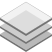
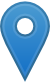

In [15]:
# HIDE CELL
m <- leaflet(data = ts_id_tide, width = 600, height = 400) %>%
  addTiles() %>%  
  addCircleMarkers(~station_longitude, ~station_latitude, popup = ~station_name, 
                   stroke=FALSE, fillOpacity = 0.6, fillColor = "#2b8cbe")
m

[This vignette](https://inbo.github.io/wateRinfo/articles/download_timeseries_batch.html) of the wateRinfo package provides the example code to download the data for multiple stations at once using the `tidyverse verbs`. We use a similar approach, but instead of manually providing the start (`from`) and end (`to`) data, we get these from the eels tracking data period:

In [16]:
start_tracking_period <- min(eels$Date)
end_tracking_period <- max(eels$Date)

tidal_data <- ts_id_tide %>%
    filter(ts_id < 100000000) %>% # hack to exclude unworking ids
    group_by(ts_id) %>%
    do(get_timeseries_tsid(.$ts_id,
                           from = start_tracking_period,
                           to = end_tracking_period,
                           datasource = 4)) %>%
    ungroup() %>%
    left_join(ts_id_tide, by = "ts_id")

In [17]:
# HIDE CELL
#tidal_data <- read_csv("../files/tidal_data.csv", col_types = cols())

In just a few lines R code, we downloaded for each of the tidal measurement stations the data for the required time period. Make sure to check out the other tutorials as well on the [wateRinfo package website](https://inbo.github.io/wateRinfo/index.html).

The water level is expressed in meter TAW (or mTAW, meter above mean sea level). By combining `dplyr` and `ggplot2`, we can plot the data of the station in Dendermonde during November 2016:

In [18]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=3)

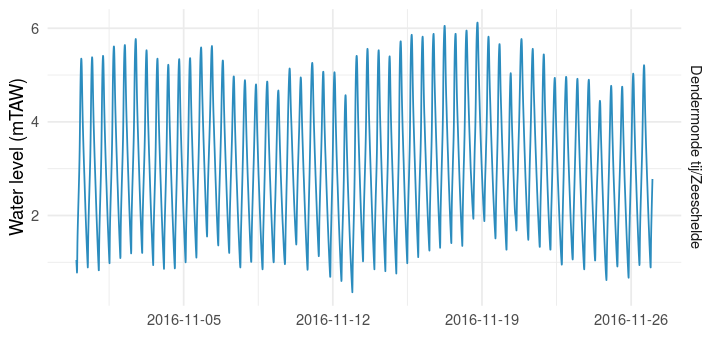

In [19]:
tidal_plot <- tidal_data %>% 
    filter(station_name %in% c("Dendermonde tij/Zeeschelde")) %>%
    filter(Timestamp > "2016-10-31", Timestamp <= "2016-11-30") %>%
    ggplot() +
        geom_line(aes(x = Timestamp, y = Value), color = "#2b8cbe") +
        scale_x_datetime(date_labels = "%Y-%m-%d",
                         date_breaks = "7 days") +
        facet_grid(rows = vars(station_name)) +
        theme_minimal() + ylab("Water level (mTAW)") + xlab("")
tidal_plot

**Note:** TAW means [*Tweede Algemene Waterpassing*](https://nl.wikipedia.org/wiki/Tweede_Algemene_Waterpassing), a reference height for Belgium

To highlight the periods of low and high tide in the figure, we want to define the moment of low and high water level peaks. We could do this by extracting the local maxima of the tidal time series or by assuming a regular interval, but these low and high water level peaks are also available as data source from waterinfo.be, using the `HWLW` keyword in the `ts_name` time serie name. So, similar to downloading the 10 minutes time series, we can download only the peaks using the wateRinfo package.

In [20]:
# HIDE CELL
ts_id_high_tide <- read_csv("../data/scheldt_tide_waterinfo_identifiers.csv", 
                            col_types = cols()) %>%
    filter(grepl("Pv.HWLW", ts_name)) %>% # use HWLW based data
    filter(station_name == "Dendermonde tij/Zeeschelde")

For the Dendermonde station the high and low flow peaks are provided by the following time series:

In [21]:
ts_id_high_tide

ts_value_id,datetime,req_timestamp,station_latitude,station_longitude,station_id,station_no,station_name,dataprovider,dataowner,significant,Portal_Bekken,station_no_short,ts_id,ts_name,parametertype_name,stationparameter_name
9,2018-11-29 15:30:00,NA,51.03456,4.103857,0419418,04zes47a-1066,Dendermonde tij/Zeeschelde,MOW-HIC,HIC,0,Beneden-Scheldebekken,zes47a-1066,54192010,Pv.HWLW,W,W


Which can be used again to download the data for a chosen period:

In [22]:
peaks_tide <- ts_id_high_tide %>% group_by(ts_id) %>%
    do(get_timeseries_tsid(.$ts_id,
                           from = min(eels$Date),
                           to = max(eels$Date),
                           datasource = 4)) %>%
    ungroup() %>%
    left_join(ts_id_high_tide, by = "ts_id") %>%
    select(Timestamp, Value, station_no, station_name) %>%
    rename(tide_value = Value)
head(peaks_tide)

Timestamp,tide_value,station_no,station_name
2016-10-11 05:50:00,0.95,04zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-11 11:23:00,4.43,04zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-11 18:49:00,0.76,04zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-12 00:21:00,4.71,04zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-12 07:38:00,0.86,04zes47a-1066,Dendermonde tij/Zeeschelde
2016-10-12 12:58:00,4.56,04zes47a-1066,Dendermonde tij/Zeeschelde


By rewrangling the data, we can translate this to tidal start and end periods:

In [23]:
tide_periods <- peaks_tide %>%
    mutate(high_water = if_else(tide_value > 3, "end", "start")) %>%
    mutate(tide_id = sort(rep(seq(1, nrow(peaks_tide)/2 + 1), 2))[1:nrow(peaks_tide)]) %>%
    select(Timestamp, tide_id, high_water) %>%
    spread(key = high_water, value = Timestamp)
head(tide_periods)

tide_id,end,start
1,2016-10-11 11:23:00,2016-10-11 05:50:00
2,2016-10-12 00:21:00,2016-10-11 18:49:00
3,2016-10-12 12:58:00,2016-10-12 07:38:00
4,2016-10-13 01:32:00,2016-10-12 20:27:00
5,2016-10-13 14:05:00,2016-10-13 08:55:00
6,2016-10-14 02:35:00,2016-10-13 21:35:00


The derived periods can be used as a background color to highlight each period between low and high tide:

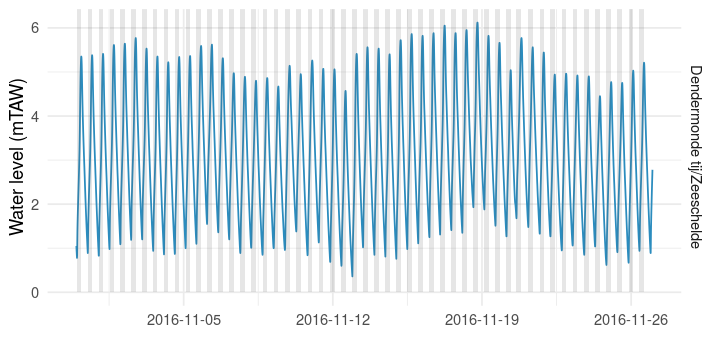

In [24]:
tidal_plot + geom_rect(data = tide_periods %>% filter(start > "2016-10-31", end <= "2016-11-30"), 
              aes(xmin = start, xmax = end, ymin = 0, ymax = Inf), 
              alpha = 0.15)

Still, to represent the data of all the individual stations together with the tracks, we'll have to figure out an alternative way. One way to combine all tidal data in a single plot is to use its respective location in the Scheldt river and translate the water height in color intensity instead of lines, resulting in a 

In [25]:
# HIDE CELL
tidal_data <- tidal_data %>%
    left_join(distance_from_sea, by = c("station_name" = "station")) %>%
    filter(station_name != 'Hemiksem tij/Zeeschelde')  # exclude data from Hemiksem

In [26]:
# HIDE CELL
options(repr.plot.width=8, repr.plot.height=6)

Warning message:
“Removed 3895 rows containing missing values (geom_segment).”

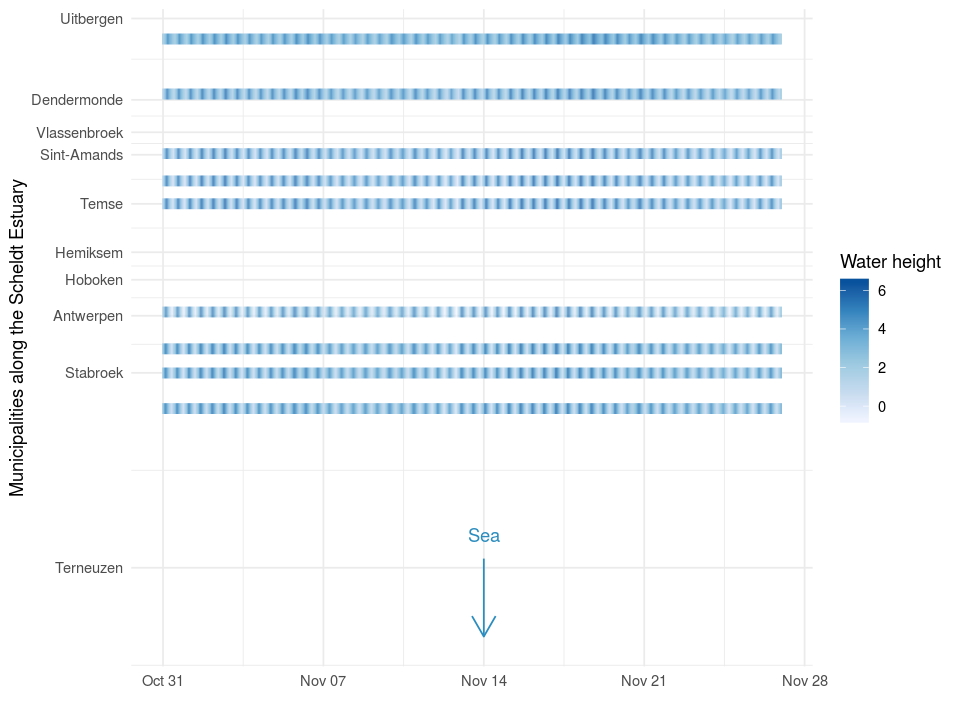

In [27]:
# HIDE CELL
tidal_plot <- ggplot() +
    geom_segment(data = tidal_data %>% filter(Timestamp > "2016-10-31", Timestamp <= "2016-11-30"), aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 3) + 
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities along the Scheldt Estuary", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    annotate("text", x = as_datetime("2016-11-14"),
             y = max(eels$distance_to_refence_station) * 0.23, 
             colour = "#2b8cbe", label = "Sea") +
    annotate("segment", x = as_datetime("2016-11-14"), xend = as_datetime("2016-11-14"),
             y = max(eels$distance_to_refence_station) * 0.2, 
             yend = max(eels$distance_to_refence_station) * 0.1, 
             arrow = arrow(length = unit(0.5, "cm")), color = "#2b8cbe") +
    theme_minimal()
tidal_plot

Each horizontal blue-shaded line is a time series downloaded from waterinfo.be and the color intensity represents the water level as function of time. 

As such, we have all the bits and pieces together to combine the tidal data set with the tracking data of Olivier during the second half of november 2016 and verify if Olivier is using the tide to move around.

## Is Olivier using the tide?

By extending the previous plot with the tracking data of Olivier, we can verify the eel movement pattern and the possible link with the water level data:

In [28]:
# HIDE CELL
start_moment <- "2016-11-14"
end_moment <- "2016-11-27"
transmitter_selected <- "A69-1601-52644"

In [29]:
# HIDE CELL
eels_subset <- eels %>% 
    filter(Departure >= start_moment, Arrival <= end_moment, 
           Transmitter == transmitter_selected)

tidal_data_subset <- tidal_data %>% 
    filter(Timestamp >= start_moment, 
           Timestamp <= end_moment)

tide_periods_subset <- tide_periods %>% 
    filter(start >= start_moment, 
           end <= end_moment)

In [30]:
# HIDE CELL
source('./plot_tidal_functions.R')

Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘ggridges’

The following object is masked from ‘package:ggplot2’:

    scale_discrete_manual



In [31]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=8)

Warning message:
“Removed 1874 rows containing missing values (geom_segment).”

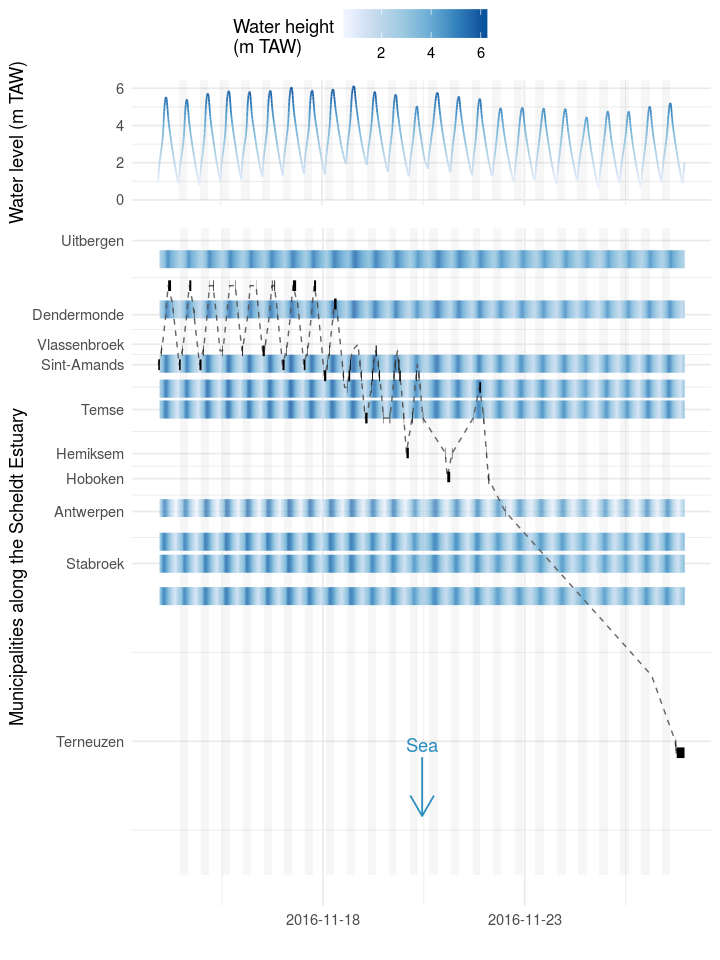

In [32]:
# HIDE CELL
# combine the eel tracking data with the tidal data representation
tidal_tracks <- plot_tidal_tracks(tidal_data_subset, eels_subset, 
                  tide_periods_subset, date_breaks = "5 days")

# create a water level plot of Dendermonde
tide_dendermonde <- plot_tide_with_background(tidal_data_subset %>% filter(station_name == "Dendermonde tij/Zeeschelde"), 
                                              tide_periods_subset, 
                                              date_breaks = "5 days") +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank()) # remove x-label elements

ggarrange(tide_dendermonde, tidal_tracks,  
          ncol = 1, nrow = 2, common.legend = TRUE,
          align = "v", heights = c(1, 5))

Looking at the graph, Olivier seems to be *lazy* and following the tidal movement for a while before setting of to the sea. When the water comes inland from the sea (higher water levels), the eel follows the water upstream. When the water returns to the sea again to low tide, the eel moves again to the direction of the sea.

For a more scientific approach to check the selective tidal stream transport of eel, check out the [scientific publication](https://www.sciencedirect.com/science/article/pii/S0272771418304530?via%3Dihub) by Pieter-Jan.

The previous figure inspired us to use the [ggridges package](https://cran.r-project.org/web/packages/ggridges/vignettes/introduction.html) to provide an alternative representation to the color intensity representation of the water levels. Instead, for each location the water level is plotted as function of time. Applying this for a small subset of the data makes the tidal behaviour of the eel even more clear:

In [33]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=3)

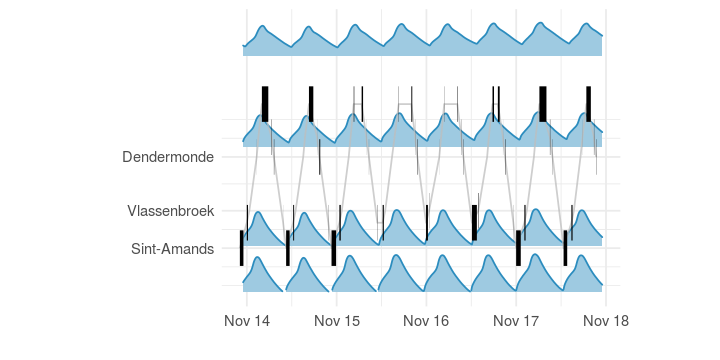

In [34]:
# HIDE CELL
library(ggridges)
ggridges_showcase(eels, tidal_data, station_municipality)

During high tide Olivier likes to be in Dendermonde (more upstream), whereas during low tide, moving downstream to Sint-Amands.

## And what about Greg?

So, Greg seemed to be much more resident on chosen locations. But what if we confront its tracks with the tidal data as well?

In [35]:
# HIDE CELL
start_moment <- "2016-10-26"
end_moment <- "2016-11-07"

eels %>% filter(Departure >= start_moment, Arrival <= end_moment,
                Transmitter == "A69-1601-52622") -> eels_subset
tidal_data %>% filter(Timestamp >= start_moment, Timestamp <= end_moment) -> tidal_data_subset

tide_periods_subset <- tide_periods %>% 
    filter(start >= start_moment, 
           end <= end_moment)

In [36]:
# HIDE CELL
options(repr.plot.width=6, repr.plot.height=8)

Warning message:
“Removed 1736 rows containing missing values (geom_segment).”

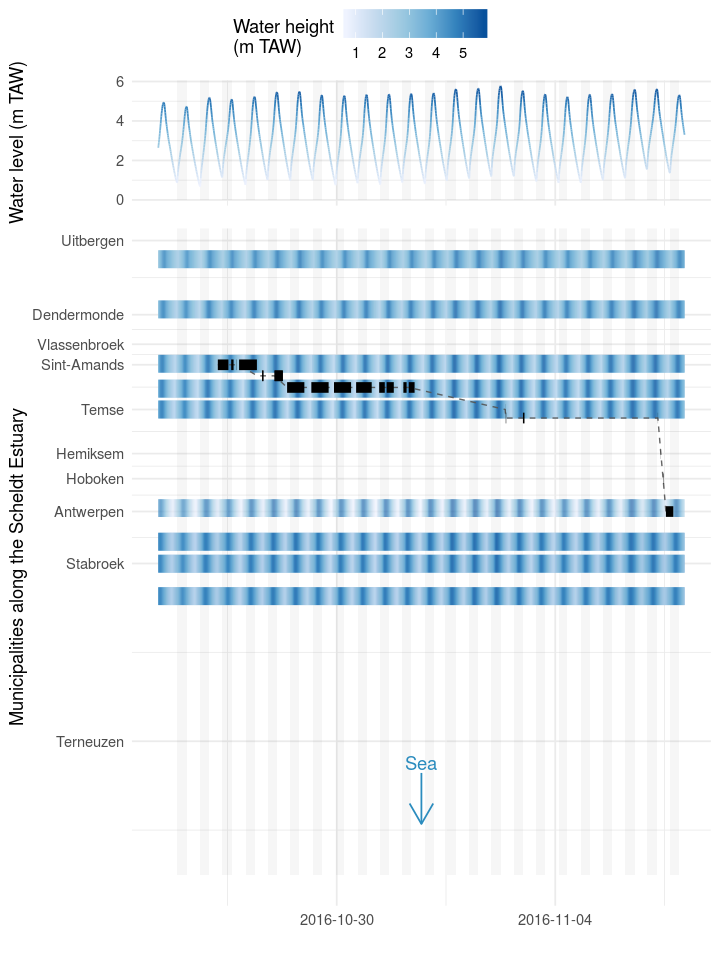

In [37]:
# HIDE CELL
# combine the eel tracking data with the tidal data representation
tidal_tracks <- plot_tidal_tracks(tidal_data_subset, eels_subset, 
                  tide_periods_subset, date_breaks = "5 days")

# create a water level plot of Dendermonde
tide_dendermonde <- plot_tide_with_background(tidal_data_subset %>% filter(station_name == "Dendermonde tij/Zeeschelde"), 
                                              tide_periods_subset, 
                                              date_breaks = "5 days") +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank()) # remove x-label elements

ggarrange(tide_dendermonde, tidal_tracks,  
          ncol = 1, nrow = 2, common.legend = TRUE,
          align = "v", heights = c(1, 5))

Actually, Greg is detected on the same location during high tide, but disappears for short periods during low tide. This indicates that Greg maybe exhibits the same pattern as Olivier after all. It could be that we are just missing the exact location of Greg during low tide periods because of the lack of a receiver at that particular location. In contrast to our [bird tracking data](https://www.gbif.org/dataset/83e20573-f7dd-4852-9159-21566e1e691e) we can not rely on a continous GPS logging for the fishtracking project, so we depend on the presence of receivers to actually measure the presence of the eel. 

Nevertheless, by linking the eels tracking data with the tidal data, we get more insight to demistify the behaviour of these very interesting species. 

For the full code of this blogpost, check out [this repository](https://github.com/stijnvanhoey/wateRinfo_post).

**Acknowledgements:**

Thanks Greg and Olivier for being our study objects and hopefully you had a save journey towards the sargasso sea. Thanks to Pieter-Jan Verhelst for the providing the data. 

We also would like to thank [Laura DeCicco](https://github.com/ldecicco-USGS) for reviewing the wateRinfo package as well as the editor [Karthik Ram](https://github.com/karthik).